In [2]:
import os
import sys
sys.path.insert(0, "/home/gstupp/projects/metaproteomics/")
BASE = "/home/gstupp/projects/Wolan/wolan/Fusion_AW_20170831"
DATA = os.path.join(BASE, "data")
OUT = os.path.join(BASE, "out")
import pandas as pd
import numpy as np
import shelve
from itertools import chain
from collections import defaultdict, Counter
from metaproteomics import utils
from tqdm import tqdm_notebook
from metaproteomics.analysis import taxonomy
from metaproteomics.analysis import DBInfo
dbinfo = DBInfo.DBInfo('compil_mgm')
from metaproteomics.file_processing import blazmass_tools
t = taxonomy.Taxonomy(host="wl-cmadmin", port=27017)
from pymongo import MongoClient
protDB = dbinfo.protDB
seqDB = dbinfo.seqDB
taxDB = MongoClient('wl-cmadmin', 27017)["TaxDB_20151009"]["TaxDB_20151009"]
taxDB.find_one()

{'_id': 2,
 'exact_match': True,
 'matched_organism': 'Paenibacillus phage phiIBB_Pl23',
 'organism': 'Paenibacillus phage phiIBB_Pl23',
 'taxid': 1337877}

In [3]:
samples = shelve.open(os.path.join(OUT,"samples.shelve"))
#sample_name = "RTsep_unenr1"
#sample = samples[sample_name]
dfs = dict()
dfs["phylum"] = dict()
dfs["family"] = dict()

sample_pep_quant = dict()
sample_sum = dict()
for sample_name, sample in samples.items():
    sample_pep_quant[sample_name] = blazmass_tools.build_pep_quant_dict(sample.dta_select)
    sample_sum[sample_name] = sum(sample_pep_quant[sample_name].values())

nf = {k:v/np.median(list(sample_sum.values())) for k,v in sample_sum.items()}

In [4]:
list(samples.keys())

['unenriched3',
 'VK5rep1',
 'VK3rep1',
 'unenriched2',
 'unenriched1',
 'Neg1rep1',
 'VK1rep1']

In [5]:
sample_pep_tax = dict()

In [15]:
for sample_name, sample in tqdm_notebook(samples.items()):
    # Do any peptides, by themselves (but restricted to the proteins ID'd in this sample),
    # point to one particular species?
    
    # in this one sample
    # get the peptides found
    peptides = blazmass_tools.get_unmod_peptides(sample.dta_select)
    if len(sample_pep_tax.get(sample_name,[])) == len(peptides):
        continue
    sample_pep_tax[sample_name] = dict()
    for peptide in tqdm_notebook(peptides, desc=sample_name):
        # for each peptide, get the proteins that contain id, but restrict to the proteins in this sample
        # i.e. the proteins that can be made with at least 2 of the peptides in this sample (as determined by dtaselect)
        prots = set(x['i'] for x in seqDB.find_one(peptide)['p'])
        prots = prots & sample.prot_ids
        # the taxids of these proteins
        x = list(taxDB.aggregate([{'$match':{'_id':{'$in':list(prots)}}},
                                  {'$group':{'_id':None,'taxid':{'$addToSet':"$taxid"}}}]))
        if x:
            taxIDs=[y for y in x[0]['taxid'] if y]
            sample_pep_tax[sample_name][peptide] = taxIDs
        else:
            sample_pep_tax[sample_name][peptide] = []

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



HBox(children=(IntProgress(value=0, description='unenriched3', max=11070), HTML(value='')))

HBox(children=(IntProgress(value=0, description='VK5rep1', max=7177), HTML(value='')))

HBox(children=(IntProgress(value=0, description='VK3rep1', max=8557), HTML(value='')))

HBox(children=(IntProgress(value=0, description='unenriched2', max=11492), HTML(value='')))

HBox(children=(IntProgress(value=0, description='unenriched1', max=11443), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Neg1rep1', max=2520), HTML(value='')))

HBox(children=(IntProgress(value=0, description='VK1rep1', max=8963), HTML(value='')))

In [16]:
sample_pep_lca = dict()
sample_pep_lcatax = dict()
for sample_name, pep_tax in tqdm_notebook(sample_pep_tax.items()):
    
    # for each peptide and associated list of taxids, get the LCA for that peptide
    sample_pep_lca[sample_name] = dict()
    all_taxids = set(chain(*pep_tax.values()))
    for pep, taxIDs in tqdm_notebook(pep_tax.items()):
        sample_pep_lca[sample_name][pep] = t.LCA(taxIDs)
    
    # get the associated taxonomy info
    sample_pep_lcatax[sample_name] = dict()
    pep_lca = sample_pep_lca[sample_name]
    all_taxids = set(pep_lca.values())
    taxdict = {x['taxid']:x for x in t.taxonomy_coll.find({'taxid': {'$in': list(all_taxids)}})}
    for pep, lca in pep_lca.items():
        if lca:
            tax = taxdict[lca]
            if tax['rank#'] and tax['rank#']>=16:
                sample_pep_lcatax[sample_name][pep] = tax

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2520), HTML(value='')))

HBox(children=(IntProgress(value=0, max=8557), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11443), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11070), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11492), HTML(value='')))

HBox(children=(IntProgress(value=0, max=7177), HTML(value='')))

HBox(children=(IntProgress(value=0, max=8963), HTML(value='')))

In [19]:
for sample_name, pep_lcatax in tqdm_notebook(sample_pep_lcatax.items()):
    
    species_pep = defaultdict(set)
    pep_species = {pep:tax['scientific_name'] for pep,tax in pep_lcatax.items()}
    for pep,species in pep_species.items():
        species_pep[species].add(pep)
            
    species_pep_list = sorted(list(species_pep.items()), key=lambda x:len(x[1]), reverse=True)
    
    with open(os.path.join(OUT,"organims_specific_peptides_{}.csv".format(sample_name)), 'w') as f:
        f.writelines('\n'.join([x[0] + ";" + ",".join(x[1]) for x in species_pep_list]))
    # Take every peptide and bring it up to family
    # Quantify family counts
    
    for rank in ["phylum", "family"]:
        organism_pep = defaultdict(set)
        for pep, lca in tqdm_notebook(sample_pep_lca[sample_name].items()):
            family = t.get_rank(lca, rank, "taxid")
            if family:
                organism_pep[family].add(pep)
        
        organism_quant = {k:sum([sample_pep_quant[sample_name][pep] for pep in peps]) for k,peps in organism_pep.items()}
        
        df = pd.DataFrame(organism_quant, index = ['count']).T
        df['organism_name'] = [t.taxid_to_taxonomy(int(x))['scientific_name'] for x in df.index]
        df=df.sort_values("count",ascending=False)
        
        df.to_csv(os.path.join(OUT,"{}_count_{}.csv".format(rank, sample_name)))
        dfs[rank][sample_name] = df

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2520), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2520), HTML(value='')))

HBox(children=(IntProgress(value=0, max=8557), HTML(value='')))

HBox(children=(IntProgress(value=0, max=8557), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11443), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11443), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11070), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11070), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11492), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11492), HTML(value='')))

HBox(children=(IntProgress(value=0, max=7177), HTML(value='')))

HBox(children=(IntProgress(value=0, max=7177), HTML(value='')))

HBox(children=(IntProgress(value=0, max=8963), HTML(value='')))

HBox(children=(IntProgress(value=0, max=8963), HTML(value='')))

In [20]:
for rank in ["phylum", "family"]:
    for sample_name, df in dfs[rank].items():
        df['taxid'] = df.index
        df['sample'] = sample_name
    all_df = pd.concat(list(dfs[rank].values()))
    all_df.to_csv(os.path.join(OUT,"{}_count.csv".format(rank)))

In [21]:
#%% pivot and plot
def to_percent(y, position):
    s = str(100 * y)
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

/usr/lib/python3/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


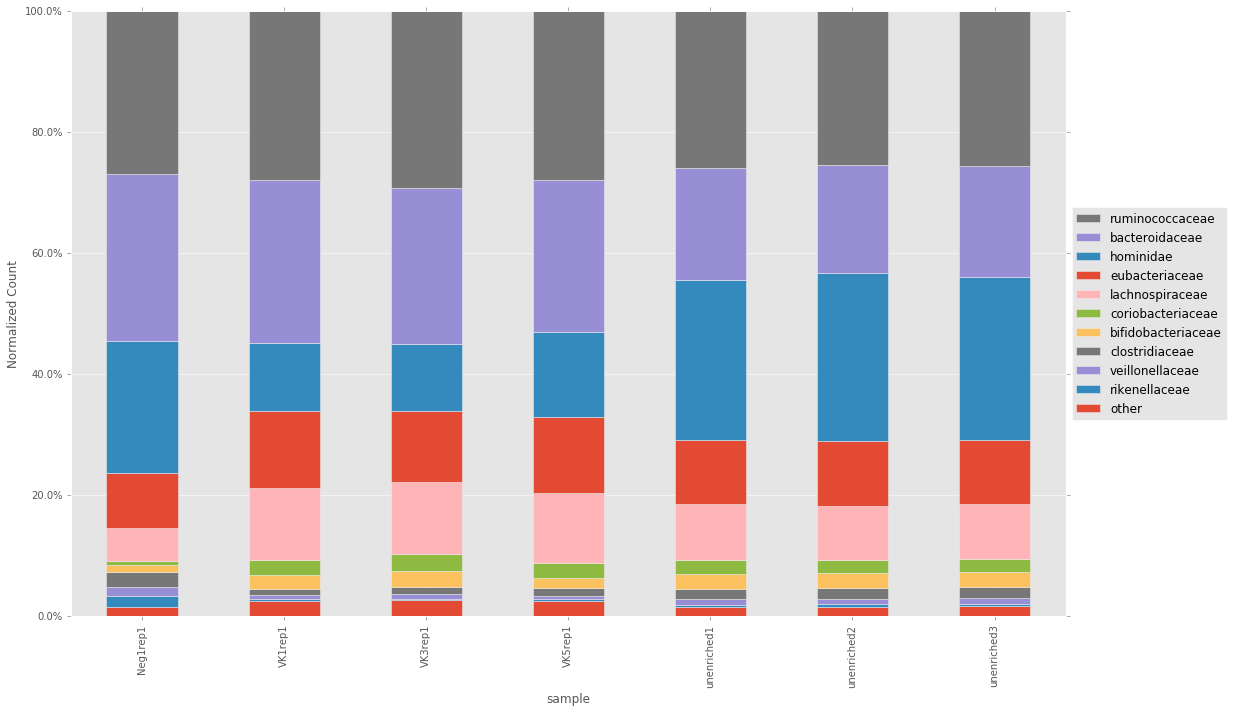

In [22]:
rank = "family"
all_df = pd.concat(list(dfs[rank].values()))
f = plt.figure(figsize=(12*1.25,8*1.25))
matplotlib.style.use('ggplot')
df_pivot = all_df.pivot_table(values="count", index="sample", columns="organism_name").dropna(1, thresh=3)
"""
if rank == "family":
    del df_pivot['muridae']
    del df_pivot['poaceae']
    del df_pivot['hominidae']
elif rank == "phylum":
    del df_pivot['chordata']
"""
df_pivot.to_csv(os.path.join(OUT,"{}_count_pivot.csv".format(rank)))
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)
df_pivot = df_pivot[df_pivot.columns[df_pivot.sum()>0.02]]
df_pivot = df_pivot[df_pivot.sum().sort_values().index]
other = pd.Series(1-df_pivot.sum(axis=1), name = "Other")
df_pivot['other'] = other
df_pivot = df_pivot[[-1]+list(range(len(df_pivot.columns)-1))]

ax = df_pivot.plot.bar(stacked=True, legend = 'reverse', ylim=(0,1), ax=f.gca())
lgd = plt.legend()
handles, labels = ax.get_legend_handles_labels()
lgd = plt.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Normalized Count")
ax.title.set_fontsize(20)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
f.subplots_adjust(right=0.8)
f.savefig(os.path.join(OUT,"{}_count_pivot.pdf".format(rank)), bbox_inches='tight')

#%%
df_sum = pd.DataFrame(df_pivot.sum(1))
df_sum['sum'] = [sample_sum[x] for x in df_sum.index]
df_sum['p'] = df_sum[0]/df_sum['sum']
df_sum.columns = ['phylum specific count', 'total', 'p']

/usr/lib/python3/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


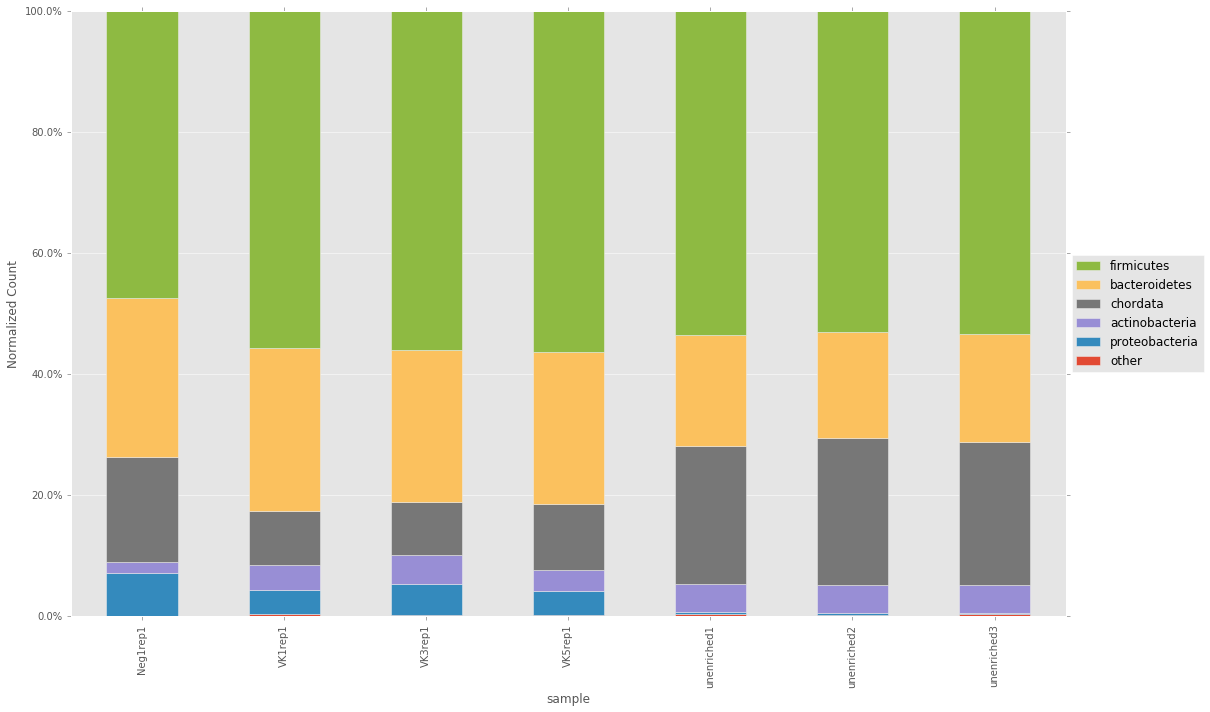

In [23]:
rank = "phylum"
all_df = pd.concat(list(dfs[rank].values()))
f = plt.figure(figsize=(12*1.25,8*1.25))
matplotlib.style.use('ggplot')
df_pivot = all_df.pivot_table(values="count", index="sample", columns="organism_name").dropna(1, thresh=3)
"""
if rank == "family":
    del df_pivot['muridae']
    del df_pivot['poaceae']
    del df_pivot['hominidae']
elif rank == "phylum":
    del df_pivot['chordata']
"""
df_pivot.to_csv(os.path.join(OUT,"{}_count_pivot.csv".format(rank)))
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)
df_pivot = df_pivot[df_pivot.columns[df_pivot.sum()>0.02]]
df_pivot = df_pivot[df_pivot.sum().sort_values().index]
other = pd.Series(1-df_pivot.sum(axis=1), name = "Other")
df_pivot['other'] = other
df_pivot = df_pivot[[-1]+list(range(len(df_pivot.columns)-1))]

ax = df_pivot.plot.bar(stacked=True, legend = 'reverse', ylim=(0,1), ax=f.gca())
lgd = plt.legend()
handles, labels = ax.get_legend_handles_labels()
lgd = plt.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Normalized Count")
ax.title.set_fontsize(20)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
f.subplots_adjust(right=0.8)
f.savefig(os.path.join(OUT,"{}_count_pivot.pdf".format(rank)), bbox_inches='tight')

#%%
df_sum = pd.DataFrame(df_pivot.sum(1))
df_sum['sum'] = [sample_sum[x] for x in df_sum.index]
df_sum['p'] = df_sum[0]/df_sum['sum']
df_sum.columns = ['phylum specific count', 'total', 'p']